In [43]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from gnuradio import channels, gr, blocks, analog, digital
import datetime as dt
import random
import sigmf
from sigmf import SigMFFile
from signals.comms import *
from signals.radar import *

from tqdm.notebook import tqdm

## Global Variables

In [44]:
# Channel parameters
snr = 1e6
noise_voltage = 10**(-snr/20)
# Modulation parameters
sampRate = 20e6
sampsPerSym = 2
symRate = sampRate / sampsPerSym
# Metadata setup
dataDir = 'data/'
filename = 'dataset'
# Create directory if it doesn't exist
Path(dataDir).mkdir(parents=True, exist_ok=True)
# Open and close the data file to create it if it doesn't exist. This is
# necessary for the SigMFFile object below
datafile = open(dataDir+filename+'.sigmf-data','w+')
datafile.close()
meta = SigMFFile(
  data_file=dataDir+filename+'.sigmf-data',
  global_info={
    SigMFFile.DATATYPE_KEY: 'cf32_le',
    SigMFFile.SAMPLE_RATE_KEY: sampRate,
    SigMFFile.AUTHOR_KEY: 'Shane Flandermeyer, shane.flandermeyer@ou.edu',
    SigMFFile.DESCRIPTION_KEY: 'Synthetic RF dataset for machine learning',
    SigMFFile.VERSION_KEY: sigmf.__version__,
  }
)


## Main Simulation Loop

In [45]:
# # Number of vectors per modulation class
# nVecClass = 10000
# # Number of samples per class vector
# # TODO: For some reason, GNU Radio always produces 8 samples less than expected,
# # so we need to add 8 to the number of samples to get the correct value
# nSamplesVec = 128+8

# # A running count of the number of samples produced
# nSamplesProduced = 0
# # A running cound of the number of vectors produced
# nIterations = 0
# # Loop through all the modulation types defined in this list
# modulations = [bpsk, qpsk]
# nClasses = len(modulations)
# nSampsTotal = (nSamplesVec-8)*nVecClass*nClasses
# data = np.zeros((nSampsTotal,), dtype=np.complex64)
# for modulation in modulations:
#     if isinstance(modulation, type):
#         # If the current element is a type object, create a new instance of that
#         # class
#         sig = modulation()
#     else:
#         # Otherwise we can just use the object directly
#         sig = modulation
#     # Create and run the flowgraph
#     # Flowgraph object
#     tb = gr.top_block()
#     # Draw 8-bit sequences from a uniform distribution
#     src = analog.random_uniform_source_b(0, 256, 0)
#     # Symbol constellation
#     constellation = sig.constellation
#     # Constellation modulator
#     mod = digital.generic_mod(
#         constellation=constellation,
#         differential=False,
#         samples_per_symbol=2,
#         pre_diff_code=True,
#         excess_bw=0.35,
#         verbose=False,
#         log=False,
#         truncate=False)
#     channel = channels.channel_model(
#         noise_voltage=noise_voltage, taps=[1])
#     # Head block to limit the number of samples
#     head = blocks.head(gr.sizeof_gr_complex, nSamplesVec)
#     # Vector sink
#     sink = blocks.vector_sink_c()
#     tb.connect(src, mod, head, channel, sink)
#     # Generate nVecClass vectors of nSamplesVec samples each
#     for iVec in tqdm(range(nVecClass)):
#         head.reset()
#         sink.reset()
#         tb.run()
#         result = sink.data()
#         # Normalize the energy to stay consistent with different modulations
#         energy = np.sum(np.abs(result)**2)
#         data[nSamplesProduced:nSamplesProduced+len(result)] = result/energy
#         # data = np.append(data, np.array(result/energy, dtype=np.complex64))
#         # Create the metadata dictionary
#         # TODO: This gets slow when we try to generate lots of data
#         detail = sig.detail
#         metaDict = {
#             SigMFFile.LABEL_KEY: sig.label,
#             SigMFFile.DATETIME_KEY: dt.datetime.utcnow().isoformat()+'Z'}
#         metaDict[sig.DETAIL_KEY] = detail.dict()
#         meta.add_annotation(nSamplesProduced, len(result), metadata=metaDict)
#         nSamplesProduced += sink.nitems_read(0)
#         nIterations += 1

# print(
#     f'Created {nIterations} sample vectors of length {int(nSamplesProduced/nIterations)}')
# # Check for mistakes and write to disk
# data.tofile(dataDir+filename+'.sigmf-data')
# assert meta.validate()
# meta.tofile(dataDir+filename)  # extension is optional


## Radar waveform simulation

In [46]:
# Number of vectors per modulation class
nVecClass = 1
# Number of samples per class vector
# TODO: For some reason, GNU Radio always produces 8 samples less than expected,
# so we need to add 8 to the number of samples to get the correct value
nSamplesVec = 128+8

# A running count of the number of samples produced
nSamplesProduced = 0
# A running cound of the number of vectors produced
nIterations = 0
# Loop through all the waveform types defined in this list
np.random.seed(0)
bandwidth = 1e6 + np.random.rand()*9e6
pulsewidth = 1e-6 + np.random.rand()*1e-6
waveforms = [LinearFMWaveform(bandwidth, pulsewidth, sampRate), SquareWaveform(pulsewidth, sampRate)]
nClasses=len(waveforms)
nSampsTotal=(nSamplesVec-8)*nVecClass*nClasses
data=np.zeros((nSampsTotal,), dtype = np.complex64)
for wave in waveforms:
    tb = gr.top_block()
    tx=wave.transmitter(nSamps = nSamplesVec)
    channel=channels.channel_model(
        noise_voltage = noise_voltage, taps = [1])
    # Vector sink
    sink=blocks.vector_sink_c()
    tb.connect(tx, channel, sink)
    # Generate nVecClass vectors of nSamplesVec samples each
    for iVec in tqdm(range(nVecClass)):
        tx.reset()
        sink.reset()
        tb.run()
        result=sink.data()
        # Normalize the energy to stay consistent with different modulations
        energy=np.sum(np.abs(result)**2)
        data[nSamplesProduced:nSamplesProduced+len(result)]=result/energy
        # data = np.append(data, np.array(result/energy, dtype=np.complex64))
        # Create the metadata dictionary
        # TODO: This gets slow when we try to generate lots of data
        detail=wave.detail
        metaDict={
            SigMFFile.LABEL_KEY: wave.label,
            SigMFFile.DATETIME_KEY: dt.datetime.utcnow().isoformat()+'Z'}
        metaDict[wave.DETAIL_KEY] = detail.dict()
        meta.add_annotation(nSamplesProduced, len(result), metadata=metaDict)
        nSamplesProduced += sink.nitems_read(0)
        nIterations += 1

print(f'Created {nIterations} sample vectors of length {int(nSamplesProduced/nIterations)}')
# Check for mistakes and write to disk
data.tofile(dataDir+filename+'.sigmf-data')
assert meta.validate()
meta.tofile(dataDir+filename)  # extension is optional


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Created 2 sample vectors of length 128


## Post Processing

1.0

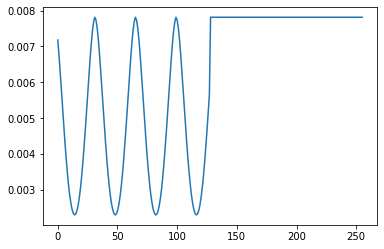

In [48]:
data = np.fromfile(dataDir+filename+'.sigmf-data', dtype=np.complex64)
plt.plot(np.real(data))
